# Automated Clustering of Similar Amendments

The Italian Senate is clogged by computer-generated amendments. This notebook aims to cluster similar amendments in an automated fashion, so that the appropriate Senate procedures can be used to get rid of them in one sweep.

We begin as usual with some imports, some Jupyter magic and some useful constants.

In [1]:
from __future__ import division

import os
import re

from itertools import combinations

import xml.etree.ElementTree as ET

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

In [2]:
%matplotlib inline

In [3]:
DATA_FOLDER = 'data'
NAMESPACE = {'an': 'http://docs.oasis-open.org/legaldocml/ns/akn/3.0/CSD03'}
ALPHANUM_REGEX = re.compile('[\W+]', re.UNICODE)

The problem we want to solve is an unsupervised clustering in an unknown number of clusters. The usual algorithm used to solve it is some variation of hierarchical clustering combined with some heuristics to "cut" the resulting dendrogram at a certain height to produce the predicted clusters.

All variations of hierarchical clustering require us to define some distance metric between elements. In our case, elements are free texts, so we use a distance related to [Jaccard Similarity](https://en.wikipedia.org/wiki/Jaccard_index) on the tokens of the text, where a _token_ is a contiguous string of alphanumeric characters.

In [4]:
def to_tokens(s):
    return set(ALPHANUM_REGEX.sub(' ', s).lower().split())

In [5]:
def jaccard_distance(x, y):    
    return 1 - (len(x['tokens'] & y['tokens']) / len(x['tokens'] | y['tokens']))

Using the XML data downloaded by the Scrapy spider, we build an array called `amendments`.
Each element of the array is a dictionary whose structure is exemplified by the following:
```python
{
    '_id': '1.100',
    'authors': ['SACCONI', "D'ASCOLA", 'AIELLO', 'ALBERTINI', ..., 'DI BIAGIO'],
    'raw': 'Sopprimere gli articoli da 1 a 10.',
    'tokens': set(['1', '10', 'a', 'articoli', 'da', 'gli', 'sopprimere'])
}
```

In [6]:
amendments = []

for filename in os.listdir(DATA_FOLDER):
    tree = ET.parse(os.path.join(DATA_FOLDER, filename))
    
    _id = tree.find('.//an:FRBRnumber', NAMESPACE).get('value')
    authors = [el.text for el in tree.findall('.//an:docProponent', NAMESPACE)]
    raw = ' '.join(tree.find('.//an:amendmentContent', NAMESPACE).itertext())
    tokens = to_tokens(raw)
    
    amendments.append({'_id': _id, 'authors': authors, 'raw': raw, 'tokens': tokens})

To check if the algorithm is working correctly, we restrict ourselves to the first hundred amendments.

In [7]:
first_amendments = amendments[:100]
first_distances = [jaccard_distance(x, y) for x, y in combinations(first_amendments, 2)]

We now compute an hierarchical clustering on these first hundred elements, and we visualize the results as a dendrogram.

In [8]:
Z_first = linkage(first_distances, method='complete')

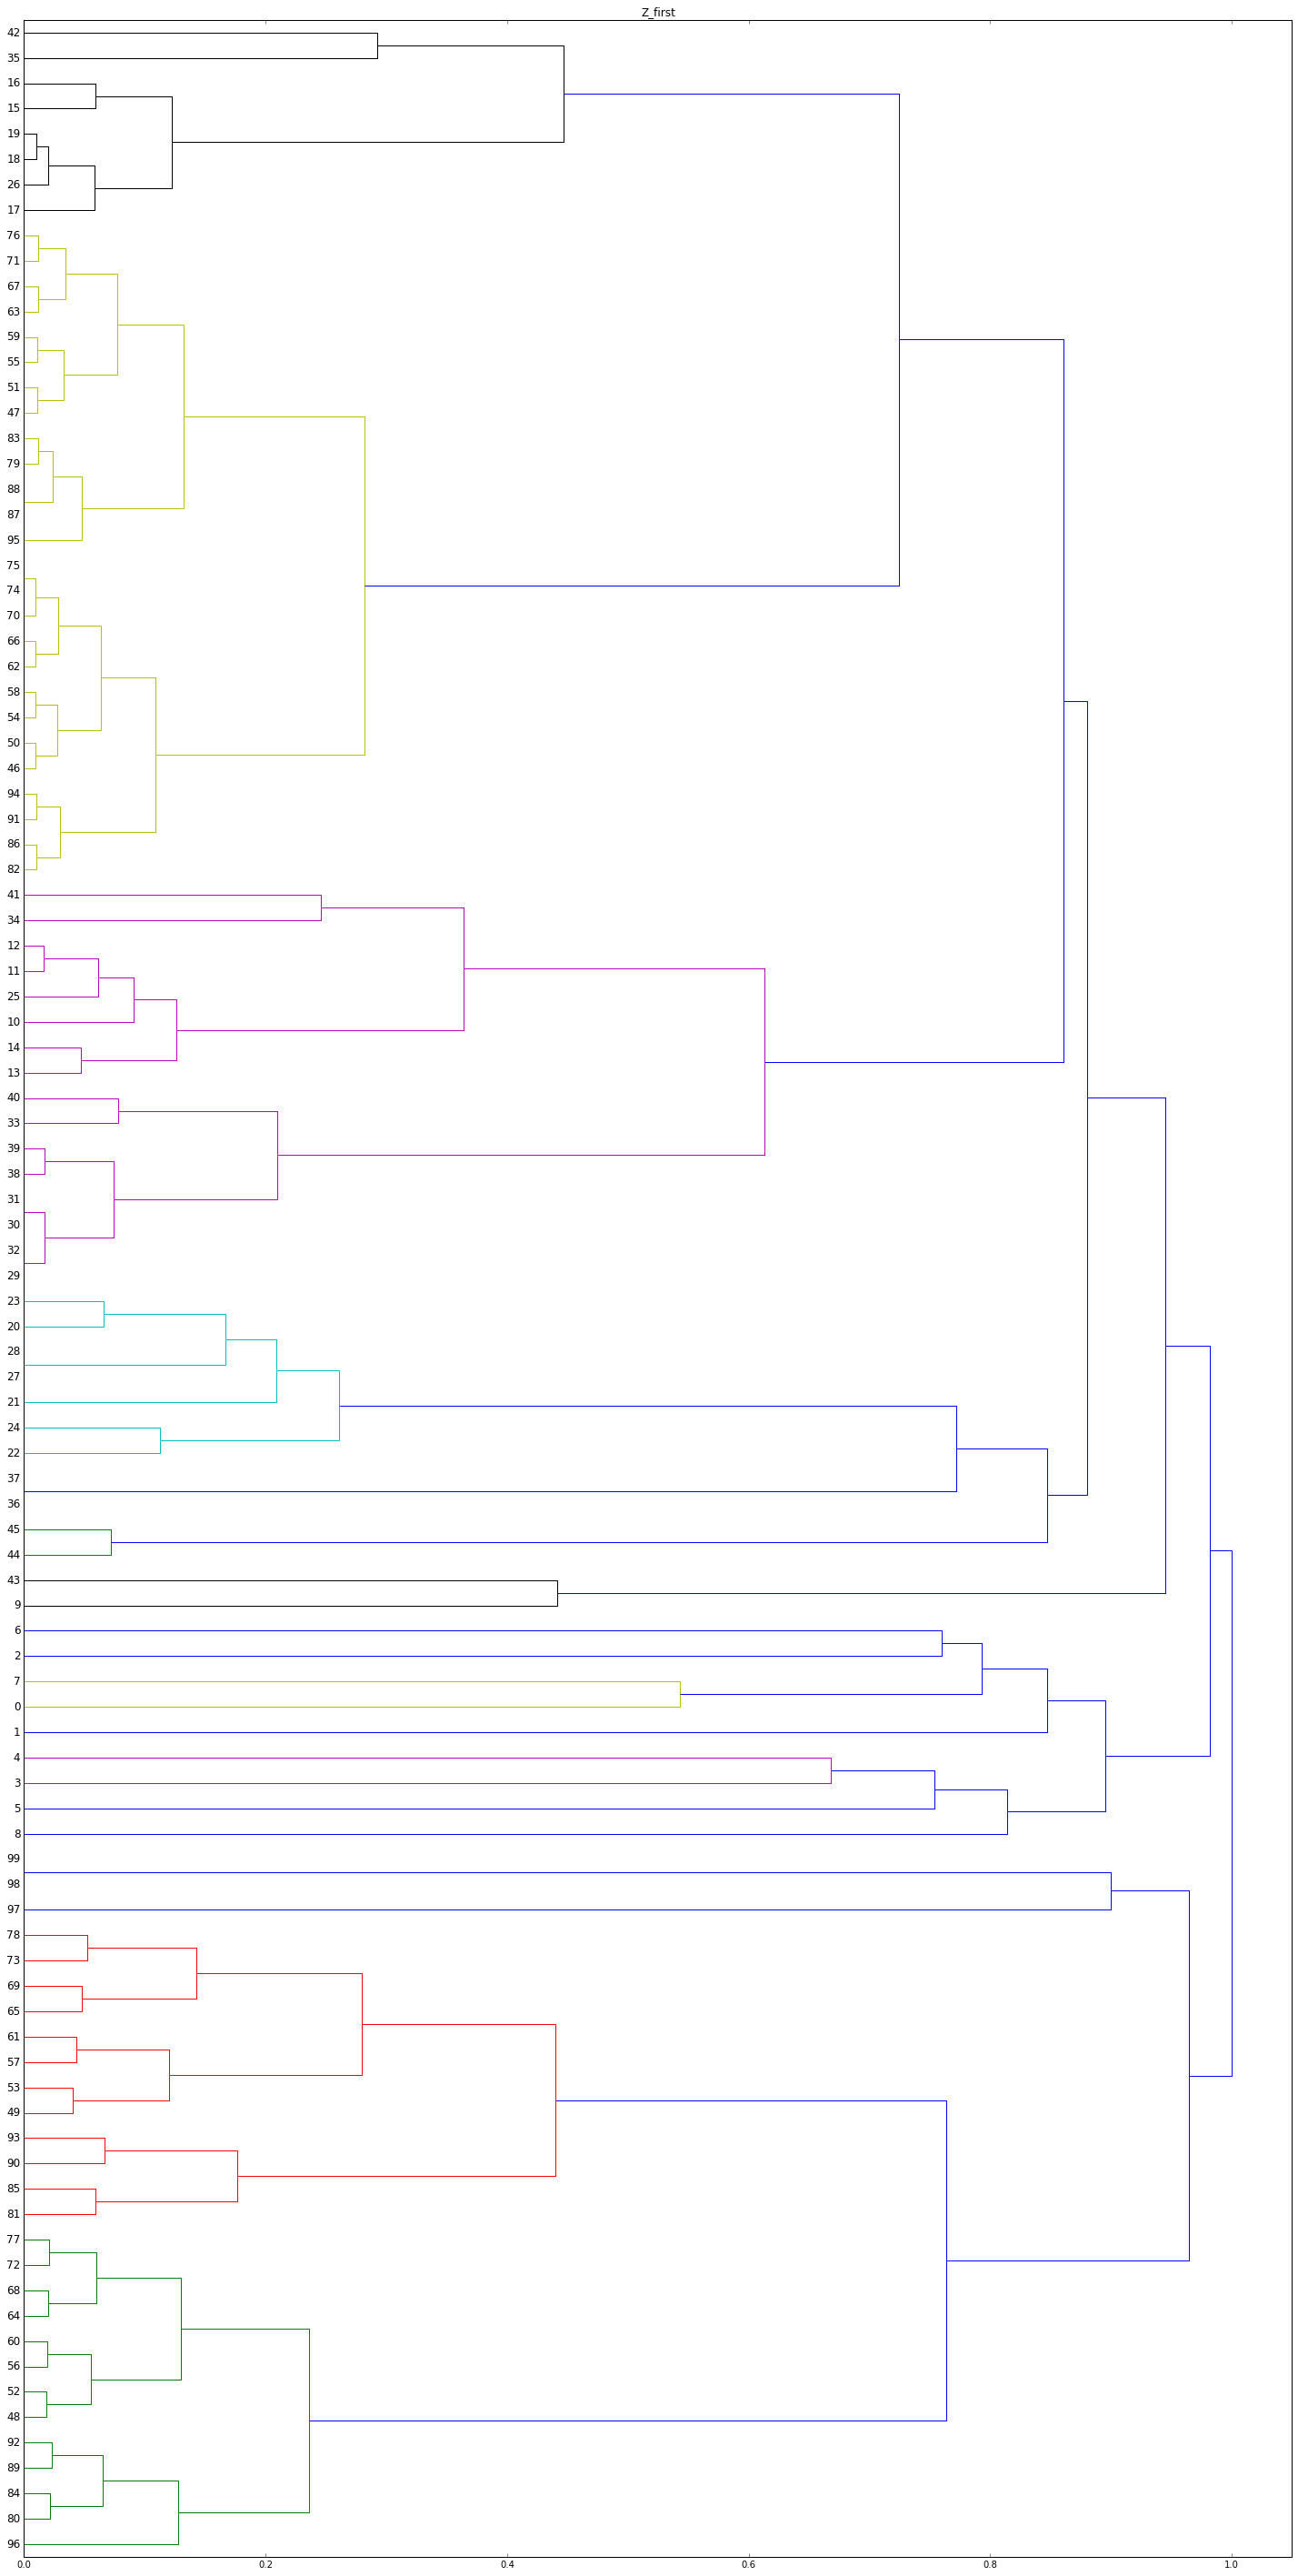

In [9]:
plt.figure(figsize=(25, 50))
plt.title('Z_first')
dendrogram(
    Z_first,
    orientation='right',
    leaf_font_size=12.,
)
plt.show()

It appears that the algorithm found several clusters, highlighted by different colors. Let's inspect the last green one:

In [10]:
for i in [77, 72, 68, 64, 60, 56, 52, 48, 92, 89, 84, 80, 96]:
    print u'{i}: {snippet}'.format(i=i, snippet=first_amendments[i]['raw'][:76])

77: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15. C
72: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
68: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
64: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
60: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
56: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
52: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
48: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
92: Sopprimere gli articoli 1, 2, 3, 4, S, 6, 7, 8, 9, 10, 11. Conseguentemente,
89: Sopprimere gli articoli 1, 2, 3,4, S, 6, 7, 8, 9, 10, 11, 12. Conseguentemen
84: Sopprimere gli articoli 1, 2, 3, 4, S, 6, 7, 8, 9, 10, 11, 12, 13. Conseguen
80: Sopprimere gli articoli 1, 2, 3, 4, S, 6, 7, 8, 9, 10, 11, 12, 13, 14. Conse
96: Sopprimere gli articoli 

We see that, in fact, all amendments of this cluster are variations of a single one.

Let's now try with the second to last red cluster:

In [11]:
for i in [78, 73, 69, 65, 61, 57, 53, 49, 93, 90, 85, 81]:
    print u'{i}: {snippet}'.format(i=i, snippet=first_amendments[i]['raw'][:76])

78: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15.
73: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
69: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
65: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
61: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
57: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
53: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
49: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
93: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11.
90: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.
85: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13.
81: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14.


Again, all amendments in this cluster are variations of a single one. Moreover, they differ from the previous cluster for the addition of the last sentence, which is why the hierarchical clustering algorithm will eventually merge the two clusters.

To double check, let's try with amendments `6` and `97`, which are not part of the same cluster:

In [12]:
for i in [6, 97]:
    print u'{i}: {snippet}'.format(i=i, snippet=first_amendments[i]['raw'][:76])

6: Il Senato,             esaminato il disegno di legge n. 2081 contenente «Reg
97: Sopprimere gli articoli da 1 a 10.


It appears that, in fact, the text of these two amendments is significantly different.

Finally, let's run the algorithm on all amendments at once.

In [13]:
distances = [jaccard_distance(x, y) for x, y in combinations(amendments, 2)]

In [14]:
Z_all = linkage(distances, method='complete')

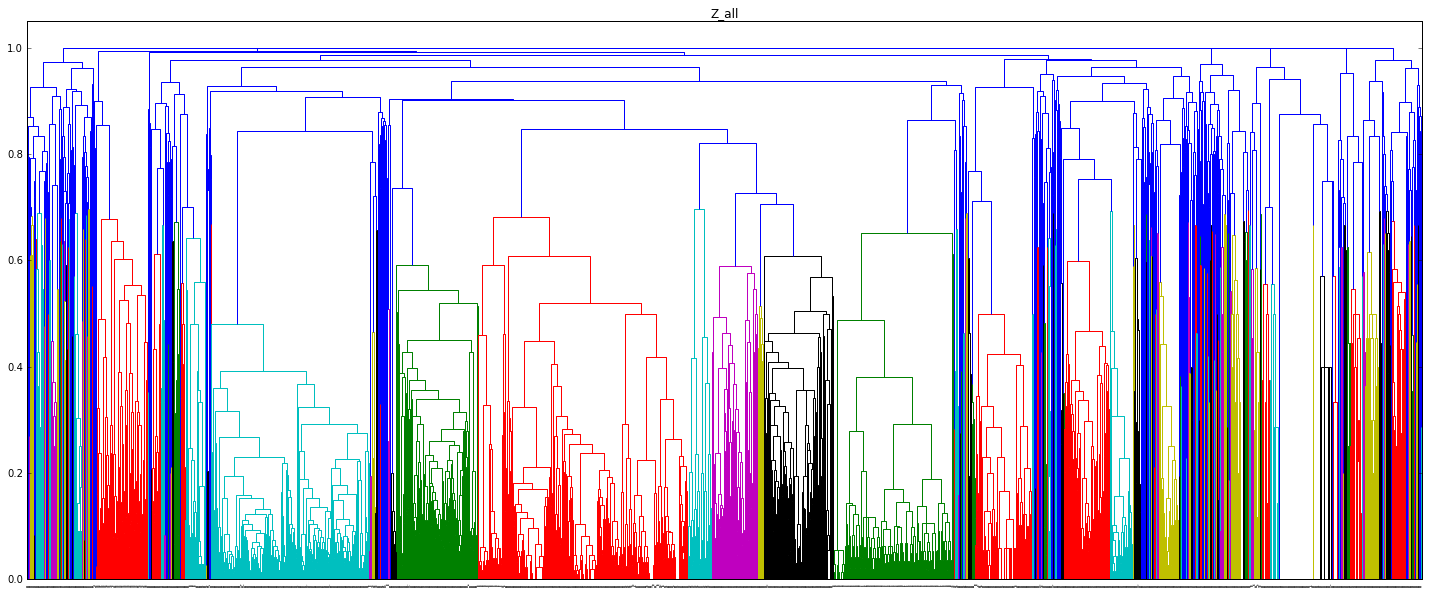

In [15]:
plt.figure(figsize=(25, 10))
plt.title('Z_all')
dendrogram(
    Z_all,
    leaf_font_size=0.,
)
plt.show()

We observe several interesting clusters, like the green one appearing roughly at two thirds from the left, and the five red ones appearing just before the middle. Moreover, this shows that the algorithm can be applied to several thousands of amendments in a couple of minutes.